In [1]:
import pandas as pd
import numpy as np
import psycopg2
import datetime
import matplotlib.pyplot as plt
import math
from scipy import stats

In [2]:
USERNAME = 'dryu'
PWD = 'VRyrf4cXDtccxT4b'
DB_HOST = [('olympus','olympus.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
           ,('atlas','atlas.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
          ,('verizon','rr.verizon.amer-ignite.digitalturbine.com')]

In [3]:
df_events = pd.read_csv('~/Downloads/Lyft_events.csv', low_memory=False)
df_installs = pd.read_csv('~/Downloads/Lyft_installs.csv', low_memory=False)

In [4]:
df_installs = df_installs.drop('timestamp', axis=1).join(df_installs['timestamp'].apply(pd.to_numeric, errors='coerce'))
print(str(df_installs['timestamp'].isna().sum()), 'invalid timestamps!')
df_installs['timestamp'] = pd.to_datetime(df_installs['timestamp'], unit='ms').astype('datetime64[ns, Europe/Paris]').dt.tz_convert('EST')
df_installs.tail(30)

5 invalid timestamps!


referrer                                  aaid    appIdentifier  \
3609440      NaN  26be98a4-e42c-4cd2-908b-d077ed7f0d9c  me.lyft.android   
3609441      NaN  53e9d938-377d-4697-997a-bd519183edd7  me.lyft.android   
3609442      NaN  ca08de42-3faf-4b77-80bf-2d908107dc5c  me.lyft.android   
3609443      NaN  9bad012b-bf9c-4dd4-8182-bfa70555c2a4  me.lyft.android   
3609444      NaN  77c0bd98-ae94-4d66-94e7-f067a84dda3a  me.lyft.android   
3609445      NaN  ca6442f7-db31-4683-ac84-7549f820a254  me.lyft.android   
3609446      NaN  f5d9f0d5-b596-4672-9b6e-22db16451730  me.lyft.android   
3609447      NaN  5a2871ba-fdfc-40c2-a188-20884450acfc  me.lyft.android   
3609448      NaN  8bbb51d1-1bd2-41b4-b26e-97214220279e  me.lyft.android   
3609449      NaN  1639380d-aa09-4450-95a3-5c5a82ccd0ca  me.lyft.android   
3609450      NaN  fd396e55-c541-43ea-81a9-418bfd30f7a8  me.lyft.android   
3609451      NaN  500f9de2-c755-434f-a818-af0e750897c1  me.lyft.android   
3609452      NaN  24b3c7c4-69ab-4ee3-a073-6f776bb54171  me.lyft.android   
3609453      NaN  eaba5244-d3f5-4710-acfd-4276313c908b  me.lyft.android   
3609454      NaN  c262c33d-3e61-4422-9ebd-05d8bf648cd4  me.lyft.android   
3609455      NaN  ec19ee5c-9c5f-4fb6-b9a5-b395050e2d26  me.lyft.android   
3609456      NaN  f2f6d328-ae6f-4196-a3ba-aa1efbe474e0  me.lyft.android   
3609457      NaN  5fc864d5-caf7-4b7e-ad95-af509eb4d52c  me.lyft.android   
3609458      NaN  7ce0546c-fcf7-4085-bf2c-5eadf109dfe8  me.lyft.android   
3609459      NaN  2fa835da-5ef3-4ed0-a3da-65b6739bb62e  me.lyft.android   
3609460      NaN  eb355d25-5349-4ec6-9ef0-5248b4bfc524  me.lyft.android   
3609461      NaN  23f8ce97-00fb-4686-b182-b82aa1fdcf73  me.lyft.android   
3609462      NaN  6c1486c7-e9b2-4dad-bd0e-97d3c11cbb00  me.lyft.android   
3609463      NaN  e060f949-786a-49ce-a0cc-bacbd56428b1  me.lyft.android   
3609464      NaN  2c6c8427-d937-44d5-98dc-3028927eb290  me.lyft.android   
3609465      NaN  9bf353c9-9327-4397-838e-6f8be7a1a96a  me.lyft.android   
3609466      NaN  bc8f7f0f-532a-44a2-8383-58f1d04ed668  me.lyft.android   
3609467      NaN  349ca3de-a3a8-4c71-aae5-70e83ec7b88e  me.lyft.android   
3609468      NaN  75800407-a622-4946-ba9d-b529a4815041  me.lyft.android   
3609469      NaN  d89ec0fd-0720-4d65-9d01-9d0753042e98  me.lyft.android   

                                  timestamp  
3609440 2021-02-03 21:53:02.150000128-05:00  
3609441 2021-02-09 17:53:02.049999872-05:00  
3609442    2021-02-18 04:17:01.520000-05:00  
3609443 2021-02-07 01:31:01.766000128-05:00  
3609444 2021-02-22 05:17:01.367000064-05:00  
3609445 2021-02-05 00:36:02.289999872-05:00  
3609446 2021-02-17 01:31:01.311000064-05:00  
3609447 2021-02-19 03:28:01.407000064-05:00  
3609448 2021-02-10 22:54:01.950000128-05:00  
3609449    2021-02-10 22:59:01.092000-05:00  
3609450    2021-02-23 04:34:03.452000-05:00  
3609451    2021-02-26 01:11:01.308000-05:00  
3609452 2021-02-26 01:15:02.503000064-05:00  
3609453 2021-02-03 05:21:03.643000064-05:00  
3609454    2021-02-03 05:29:02.192000-05:00  
3609455 2021-02-08 04:24:03.049999872-05:00  
3609456 2021-02-05 01:30:02.966000128-05:00  
3609457    2021-02-08 04:28:01.084000-05:00  
3609458    2021-02-04 03:40:02.144000-05:00  
3609459 2021-02-07 02:33:01.816999936-05:00  
3609460 2021-02-07 02:34:01.939000064-05:00  
3609461 2021-02-10 01:44:01.303000064-05:00  
3609462 2021-02-24 04:53:01.795000064-05:00  
3609463    2021-02-09 04:42:02.216000-05:00  
3609464 2021-02-04 03:58:01.319000064-05:00  
3609465    2021-02-10 01:23:01.416000-05:00  
3609466    2021-02-03 02:33:02.088000-05:00  
3609467 2021-02-08 01:14:01.636999936-05:00  
3609468 2021-02-04 01:58:01.972999936-05:00  
3609469 2021-02-04 02:34:01.784999936-05:00

In [5]:
df_events = df_events.drop('date', axis=1).join(df_events['date'].apply(pd.to_datetime, errors='coerce'))
print(str(df_events['date'].isna().sum()), 'invalid timestamps!')
df_events['referrer'] = df_events['referrer'].replace('empty',np.nan)
df_events['date'] = df_events['date'].astype('datetime64[ns, EST]')
df_events.tail(30)

0 invalid timestamps!


referrer                                  aaid            appId  \
735339      NaN  1870c7c8-8d7d-41bb-aa3e-e5335c4f3b69  me.lyft.android   
735340      NaN  fe94dbf2-a51f-4ec5-8935-1e4571005a3c  me.lyft.android   
735341      NaN  b1bdba9a-1b83-482c-b135-b8df6921409f  me.lyft.android   
735342      NaN  3acc2c45-fb52-4f77-b4b9-b655f78735fe  me.lyft.android   
735343      NaN  b94f3719-f152-4feb-957e-5de6671e2da2  me.lyft.android   
735344      NaN  d3c505d5-7ef8-45c4-bcb6-c02d1d8edd02  me.lyft.android   
735345      NaN  71d919b7-7308-4faa-8766-bc34ec48c2fe  me.lyft.android   
735346      NaN  3ceef868-78e9-4efe-9ac8-3395036ddfe9  me.lyft.android   
735347      NaN  cfae4a96-691b-41f0-8610-cbc23b32177f  me.lyft.android   
735348      NaN  8b955b70-fb04-45c8-b5d7-dac2c3e46c47  me.lyft.android   
735349      NaN  fd087d4c-d339-4a0c-ad2c-768a6c5db1a0  me.lyft.android   
735350      NaN  6e3169bc-9593-4363-b4a9-eda142dfa0c2  me.lyft.android   
735351      NaN  3f049383-59cb-4459-99b9-ccea291cfe51  me.lyft.android   
735352      NaN  b305fc55-7aa0-4748-8a46-aa72916bebe6  me.lyft.android   
735353      NaN  f6498bc0-e75e-4ad9-8b6c-2bdd6126c390  me.lyft.android   
735354      NaN  9a6d1e1a-81da-4fd9-b809-282e56a020d5  me.lyft.android   
735355      NaN  d2d8e711-9c2e-4864-b9be-2e3d929ddae0  me.lyft.android   
735356      NaN  2dfb3a61-76f9-4325-9a35-d99907ba6495  me.lyft.android   
735357      NaN  c8ba60d9-48eb-40b1-91e6-6e979853975c  me.lyft.android   
735358      NaN  95634037-8c14-4638-b98a-0f39d8a84d15  me.lyft.android   
735359      NaN  c866ad45-09c3-482a-acf0-3ef20ea478c0  me.lyft.android   
735360      NaN  1dc3c704-9d02-452e-9cdc-fc0d4cf0c3ea  me.lyft.android   
735361      NaN  d632bf27-ff69-4a9e-af6a-a0fd70729851  me.lyft.android   
735362      NaN  ae8ba51c-055f-496a-846b-ac6c40f1d6d9  me.lyft.android   
735363      NaN  4ada32b7-5ac5-47ff-a81a-bcffe0bf83a4  me.lyft.android   
735364      NaN  69a0363f-9d4f-47d1-8b29-9f37de1de44b  me.lyft.android   
735365      NaN  6ebbd99b-8ef1-4f66-a7c8-260873c7bfb3  me.lyft.android   
735366      NaN  d1fb8980-caa3-478a-be12-7808d8ba8630  me.lyft.android   
735367      NaN  f644da0b-cad4-4d87-9a89-ac98a3300b09  me.lyft.android   
735368      NaN  5b5cacfb-e68d-4490-a43d-8f5be8b70738  me.lyft.android   

           event  eventVar                      date  
735339  purchase       NaN 2021-03-10 00:31:16-05:00  
735340  purchase       NaN 2021-03-10 00:31:16-05:00  
735341  purchase       NaN 2021-03-10 00:31:16-05:00  
735342  purchase       NaN 2021-03-10 00:32:16-05:00  
735343  purchase       NaN 2021-03-10 00:32:19-05:00  
735344  purchase       NaN 2021-03-10 00:32:49-05:00  
735345  purchase       NaN 2021-03-10 00:32:55-05:00  
735346  purchase       NaN 2021-03-10 00:33:04-05:00  
735347  purchase       NaN 2021-03-10 00:33:07-05:00  
735348  purchase       NaN 2021-03-10 00:33:46-05:00  
735349  purchase       NaN 2021-03-10 00:33:52-05:00  
735350  purchase       NaN 2021-02-25 23:51:25-05:00  
735351  purchase       NaN 2021-02-25 23:51:31-05:00  
735352  purchase       NaN 2021-02-25 23:51:34-05:00  
735353  purchase       NaN 2021-02-25 23:51:50-05:00  
735354  purchase       NaN 2021-02-25 23:52:47-05:00  
735355  purchase       NaN 2021-02-25 23:52:56-05:00  
735356  purchase       NaN 2021-03-07 00:45:28-05:00  
735357  purchase       NaN 2021-03-07 00:45:28-05:00  
735358  purchase       NaN 2021-03-07 00:45:34-05:00  
735359  purchase       NaN 2021-03-07 00:45:34-05:00  
735360  purchase       NaN 2021-03-07 00:45:34-05:00  
735361  purchase       NaN 2021-03-07 00:45:37-05:00  
735362  purchase       NaN 2021-03-07 00:45:37-05:00  
735363  purchase       NaN 2021-03-07 00:48:58-05:00  
735364  purchase       NaN 2021-03-07 00:48:58-05:00  
735365  purchase       NaN 2021-03-07 00:49:01-05:00  
735366  purchase       NaN 2021-03-07 00:49:04-05:00  
735367  purchase       NaN 2021-03-07 00:50:19-05:00  
735368  purchase       NaN 2021-03-07 00:50:19-05:00

In [6]:
df = pd.merge(df_installs,df_events, left_on = ['aaid','referrer'], right_on = ['aaid','referrer'], how = 'left', suffixes = ('_install', '_event'))
df = df[['referrer','aaid','appIdentifier','timestamp','date']]
df.columns = ['referrer_install','aaid','appid','timestamp_install','timestamp_event']
df.dtypes

referrer_install                  object
aaid                              object
appid                             object
timestamp_install    datetime64[ns, EST]
timestamp_event      datetime64[ns, EST]
dtype: object

In [7]:
df['DT_install'] = df['referrer_install'].str.contains('APPIA', na=False)
df = df[(df['timestamp_event'] >= df['timestamp_install']) | (df['timestamp_event'].isna())]

install_start_dt = min(df.loc[(df.referrer_install.str.contains('APPIA', na=False)) 
                            & (~df.referrer_install.str.contains('APPIAOS', na=False))
                            ,'timestamp_install']).date().strftime('%Y-%m-%d')
install_end_dt = max(df.loc[df.referrer_install.str.contains('APPIA', na=False),'timestamp_install']).date().strftime('%Y-%m-%d')
print(install_start_dt, install_end_dt)

2021-02-04 2021-04-24


In [8]:
by_attribution = df.groupby('DT_install')[['timestamp_install','timestamp_event']].count()
by_attribution['event_rate'] = by_attribution['timestamp_event']/by_attribution['timestamp_install']
by_attribution

timestamp_install  timestamp_event  event_rate
DT_install                                                
False                 3204817           290236    0.090562
True                    56678             1280    0.022584

In [9]:
conn_olympus = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                                f"dbname={DB_HOST[0][0]} host={DB_HOST[0][1]}")
conn_atlas = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                              f"dbname={DB_HOST[1][0]} host={DB_HOST[1][1]}")
cur_olympus = conn_olympus.cursor()
cur_atlas = conn_atlas.cursor()

In [10]:
query_preload = """
    select
        aaid
        , preload_type
        , t.site_name
        , t.site_id
        , tracking_time as timestamp_preload
        , case when device_app_preloads > 0 then 'test' else 'control' end as test_audience
    from
    (
        select 
            ctp.advertising_id as aaid 
            , tracking_time
            , case when android_package_name = 'me.lyft.android' then 1 else 0 end as is_app_preload
            , ctp.site_id
            , max(s.site_name) as site_name
            , case when site_name like '%AppSelect%' then 'AppSelect' else 'Silent' end as preload_type
            , sum(count(case when android_package_name = 'me.lyft.android' then 1 else NULl end)) 
                over (partition by ctp.advertising_id) as device_app_preloads
        from rawdata.campaign_tracking_active_preload ctp 
        join (
            select
                date(tracking_time) as preload_dt
                , site_id
            from rawdata.campaign_tracking_active_preload
                where android_package_name = 'me.lyft.android'    
                and date(tracking_time) >= date('{start_dt}')
                and date(tracking_time) <= date('{end_dt}')
            group by 1,2
        ) app
            on ctp.site_id = app.site_id
            and date(ctp.tracking_time) = app.preload_dt
        join rawdata.site s 
            on ctp.site_id = s.site_id
        where 
            date(tracking_time) >= date('{start_dt}')
            and date(tracking_time) <= date('{end_dt}')
        group by 1,2,3,4,6
    ) t
    where
        (device_app_preloads > 0 and is_app_preload = 1) --is test device, and is a test app preload
        or (device_app_preloads = 0 and is_app_preload = 0) --is control device, and is non-test-app preload
    group by 1,2,3,4,5,6
"""

In [11]:
df_preload_list = []
for dt in pd.date_range(start = install_start_dt, end = install_end_dt, freq = '7D'):
    start_dt = dt.strftime('%Y-%m-%d')
    end_dt = min(install_end_dt, (dt + datetime.timedelta(days = 6)).strftime('%Y-%m-%d'))
    print('Running date range',start_dt,'to',end_dt)
    cur_atlas.execute(query_preload.format(start_dt = start_dt, end_dt = end_dt))
    df_sub = pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description])
    df_preload_list.append(df_sub)

Running date range 2021-02-04 to 2021-02-10
Running date range 2021-02-11 to 2021-02-17
Running date range 2021-02-18 to 2021-02-24
Running date range 2021-02-25 to 2021-03-03
Running date range 2021-03-04 to 2021-03-10
Running date range 2021-03-11 to 2021-03-17
Running date range 2021-03-18 to 2021-03-24
Running date range 2021-03-25 to 2021-03-31
Running date range 2021-04-01 to 2021-04-07
Running date range 2021-04-08 to 2021-04-14
Running date range 2021-04-15 to 2021-04-21
Running date range 2021-04-22 to 2021-04-24


In [12]:
df_preload = pd.concat(df_preload_list)
df_preload['timestamp_preload'] = df_preload.timestamp_preload.astype('datetime64[ns, EST]')

#filter date range
filters = (df_preload.timestamp_preload.dt.date >= datetime.date(2021,2,4)) & (df_preload.timestamp_preload.dt.date <= datetime.date.today() - datetime.timedelta(days = 1)) 
df_preload_filtered = df_preload[filters]

In [13]:
print('Control/Test # of Unique Preloads:',df_preload_filtered.loc[df_preload_filtered.test_audience == 'control','aaid'].nunique(),df_preload_filtered.loc[df_preload_filtered.test_audience == 'test','aaid'].nunique())

Control/Test # of Unique Preloads: 2025742 327386


In [14]:
df_merged = pd.merge(df,df_preload_filtered,left_on = 'aaid',right_on = 'aaid')

# install between 0 and 30 days since preload/notification (only keep preloads with installs)
df_merged = df_merged[((df_merged.timestamp_install - df_merged.timestamp_preload).dt.days <= 30)
                     & ((df_merged.timestamp_install - df_merged.timestamp_preload).astype('timedelta64[s]') >= 0)]

# events happening after install (99.5%) or no event for this install
df_merged = df_merged[((df_merged.timestamp_event - df_merged.timestamp_install).astype('timedelta64[s]') >= 0) 
                     | (df_merged.timestamp_event.isna())]

df_merged

referrer_install                                  aaid  \
0                   NaN  17c4453a-3afd-4d5a-9333-c567eedb73d9   
1                   NaN  17c4453a-3afd-4d5a-9333-c567eedb73d9   
2                   NaN  17c4453a-3afd-4d5a-9333-c567eedb73d9   
3                   NaN  17c4453a-3afd-4d5a-9333-c567eedb73d9   
4                   NaN  17c4453a-3afd-4d5a-9333-c567eedb73d9   
...                 ...                                   ...   
911398              NaN  ca6442f7-db31-4683-ac84-7549f820a254   
911399              NaN  ca6442f7-db31-4683-ac84-7549f820a254   
911400              NaN  ca6442f7-db31-4683-ac84-7549f820a254   
911401              NaN  ca6442f7-db31-4683-ac84-7549f820a254   
911402              NaN  ca6442f7-db31-4683-ac84-7549f820a254   

                  appid                   timestamp_install timestamp_event  \
0       me.lyft.android 2021-03-23 17:31:02.089999872-05:00             NaT   
1       me.lyft.android 2021-03-23 17:31:02.089999872-05:00             NaT   
2       me.lyft.android 2021-03-23 17:31:02.089999872-05:00             NaT   
3       me.lyft.android 2021-03-23 17:31:02.089999872-05:00             NaT   
4       me.lyft.android 2021-03-23 17:31:02.089999872-05:00             NaT   
...                 ...                                 ...             ...   
911398  me.lyft.android 2021-02-05 00:36:02.289999872-05:00             NaT   
911399  me.lyft.android 2021-02-05 00:36:02.289999872-05:00             NaT   
911400  me.lyft.android 2021-02-05 00:36:02.289999872-05:00             NaT   
911401  me.lyft.android 2021-02-05 00:36:02.289999872-05:00             NaT   
911402  me.lyft.android 2021-02-05 00:36:02.289999872-05:00             NaT   

        DT_install preload_type  \
0            False       Silent   
1            False       Silent   
2            False       Silent   
3            False       Silent   
4            False       Silent   
...            ...          ...   
911398       False       Silent   
911399       False       Silent   
911400       False       Silent   
911401       False       Silent   
911402       False       Silent   

                                                site_name site_id  \
0                   DT - Tracfone - Ignite - Blu - B100DL   11750   
1                   DT - Tracfone - Ignite - Blu - B100DL   11750   
2                   DT - Tracfone - Ignite - Blu - B100DL   11750   
3                   DT - Tracfone - Ignite - Blu - B100DL   11750   
4                   DT - Tracfone - Ignite - Blu - B100DL   11750   
...                                                   ...     ...   
911398  DT - Cricket - US - Ignite - LG - Stylo 6 - LM...   11960   
911399  DT - Cricket - US - Ignite - LG - Stylo 6 - LM...   11960   
911400  DT - Cricket - US - Ignite - LG - Stylo 6 - LM...   11960   
911401  DT - Cricket - US - Ignite - LG - Stylo 6 - LM...   11960   
911402  DT - Cricket - US - Ignite - LG - Stylo 6 - LM...   11960   

               timestamp_preload test_audience  
0      2021-03-18 16:07:40-05:00       control  
1      2021-03-18 16:00:42-05:00       control  
2      2021-03-18 16:01:00-05:00       control  
3      2021-03-18 16:04:36-05:00       control  
4      2021-03-18 16:06:07-05:00       control  
...                          ...           ...  
911398 2021-02-04 09:07:51-05:00       control  
911399 2021-02-04 09:06:53-05:00       control  
911400 2021-02-04 09:01:12-05:00       control  
911401 2021-02-04 08:50:52-05:00       control  
911402 2021-02-04 08:52:15-05:00       control  

[745036 rows x 11 columns]

(0.0, 0.5)

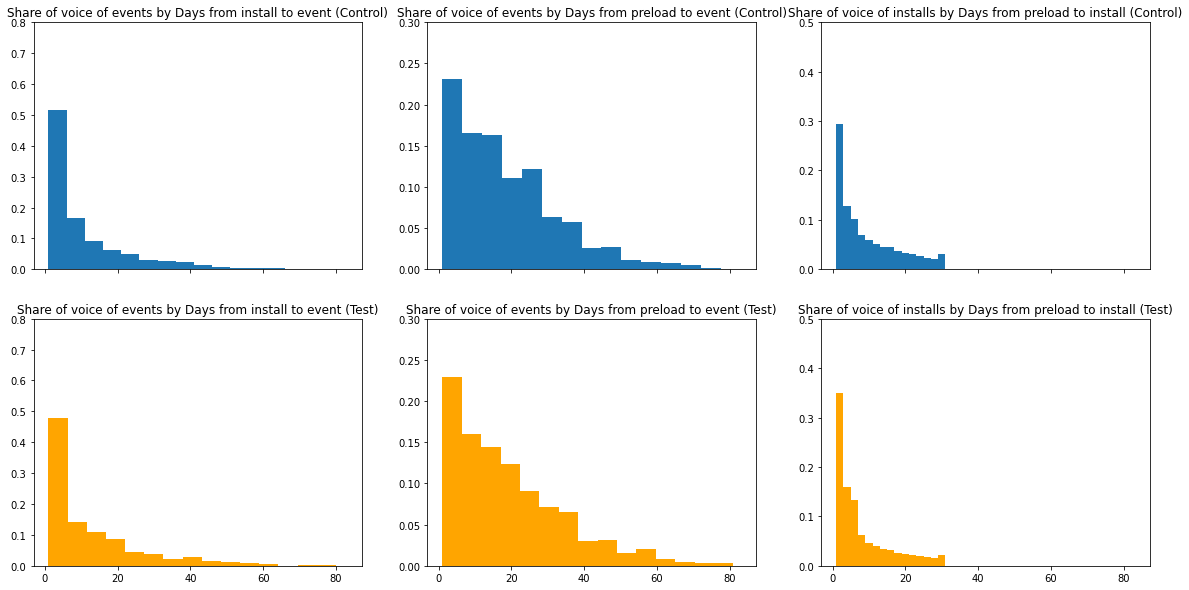

In [15]:
df_merged['preload_to_install'] = np.ceil((df_merged['timestamp_install'] - df_merged['timestamp_preload']).dt.total_seconds()/86400.)
df_merged['install_to_event'] = np.ceil((df_merged['timestamp_event'] - df_merged['timestamp_install']).dt.total_seconds()/86400.)
df_merged['preload_to_event'] = np.ceil((df_merged['timestamp_event'] - df_merged['timestamp_preload']).dt.total_seconds()/86400.)

fig, ax = plt.subplots(2,3, figsize = (20,10), sharex = True)

install_to_event_control = df_merged.loc[(~df_merged['install_to_event'].isna()) & (df_merged.test_audience == 'control'), 'install_to_event']
install_to_event_test = df_merged.loc[(~df_merged['install_to_event'].isna()) & (df_merged.test_audience == 'test'), 'install_to_event']
preload_to_event_control = df_merged.loc[(~df_merged['preload_to_event'].isna()) & (df_merged.test_audience == 'control'), 'preload_to_event']
preload_to_event_test = df_merged.loc[(~df_merged['preload_to_event'].isna()) & (df_merged.test_audience == 'test'), 'preload_to_event']
preload_to_install_control = df_merged.loc[(~df_merged['preload_to_install'].isna()) & (df_merged.test_audience == 'control'), 'preload_to_install']
preload_to_install_test = df_merged.loc[(~df_merged['preload_to_install'].isna()) & (df_merged.test_audience == 'test'), 'preload_to_install']
bins = 15

ax[0,0].hist(install_to_event_control, bins = bins, weights=np.ones(len(install_to_event_control)) / len(install_to_event_control))
ax[0,0].set_title('Share of voice of events by Days from install to event (Control)')
ax[0,0].set_ylim(0,.8)
ax[1,0].hist(install_to_event_test, bins = bins, color = 'orange', weights=np.ones(len(install_to_event_test)) / len(install_to_event_test))
ax[1,0].set_title('Share of voice of events by Days from install to event (Test)')
ax[1,0].set_ylim(0,.8)
ax[0,1].hist(preload_to_event_control, bins = bins, weights=np.ones(len(preload_to_event_control)) / len(preload_to_event_control))
ax[0,1].set_title('Share of voice of events by Days from preload to event (Control)')
ax[0,1].set_ylim(0,.3)
ax[1,1].hist(preload_to_event_test, bins = bins, color = 'orange', weights=np.ones(len(preload_to_event_test)) / len(preload_to_event_test))
ax[1,1].set_title('Share of voice of events by Days from preload to event (Test)')
ax[1,1].set_ylim(0,.3)
ax[0,2].hist(preload_to_install_control, bins = bins, weights=np.ones(len(preload_to_install_control)) / len(preload_to_install_control))
ax[0,2].set_title('Share of voice of installs by Days from preload to install (Control)')
ax[0,2].set_ylim(0,.5)
ax[1,2].hist(preload_to_install_test, bins = bins, color = 'orange', weights=np.ones(len(preload_to_install_test)) / len(preload_to_install_test))
ax[1,2].set_title('Share of voice of installs by Days from preload to install (Test)')
ax[1,2].set_ylim(0,.5)

In [16]:
# need to pivot by device in order to count only unique installs/events
# simple "count" will double-count installs and events, but we will dedupe for unique installs/events next cell
df_by_device = df_merged.pivot_table(values = ['timestamp_install','timestamp_event'], index = ['test_audience','aaid'], aggfunc = 'count')
df_by_device

timestamp_event  \
test_audience aaid                                                    
control       00042896-0d59-4cb9-a78b-82c3b7a98529                0   
              00051134-7846-486d-afc6-68c62b84b208                0   
              0005cc0d-61f1-4fa8-96d7-6a252c0074cf                0   
              00060889-0393-4761-a448-5527e2d07ae7                0   
              0009b7fc-0e3b-481b-b576-86c82e9edf9e                0   
...                                                             ...   
test          fff82cb6-00ef-4052-a242-511478553532                0   
              fff92851-55f3-4eb9-8dce-9452d2c09a03                0   
              fffc9402-575d-431e-b2e0-3a7c5a12a039                0   
              fffd681e-a2af-4cab-b49a-06d37e75c7bd                0   
              fffe3074-4f96-4b8d-bf11-3f6821f84765                0   

                                                    timestamp_install  
test_audience aaid                                                     
control       00042896-0d59-4cb9-a78b-82c3b7a98529                 10  
              00051134-7846-486d-afc6-68c62b84b208                 11  
              0005cc0d-61f1-4fa8-96d7-6a252c0074cf                 36  
              00060889-0393-4761-a448-5527e2d07ae7                  2  
              0009b7fc-0e3b-481b-b576-86c82e9edf9e                 19  
...                                                               ...  
test          fff82cb6-00ef-4052-a242-511478553532                  1  
              fff92851-55f3-4eb9-8dce-9452d2c09a03                  2  
              fffc9402-575d-431e-b2e0-3a7c5a12a039                  1  
              fffd681e-a2af-4cab-b49a-06d37e75c7bd                  2  
              fffe3074-4f96-4b8d-bf11-3f6821f84765                  1  

[102207 rows x 2 columns]

In [17]:
df_preload_filtered.loc[df_preload_filtered.test_audience == 'control', 'aaid'].drop_duplicates().to_csv(f'Lyft_control_{install_start_dt}_{install_end_dt}.csv', index = False)
df_preload_filtered.loc[df_preload_filtered.test_audience == 'test', 'aaid'].drop_duplicates().to_csv(f'Lyft_test_{install_start_dt}_{install_end_dt}.csv', index = False)

In [18]:
df_audience = df_by_device.pivot_table(values = ['timestamp_install','timestamp_event'], index = 'test_audience', aggfunc = lambda x:(x>0).sum())
df_audience.columns = ['u_events','u_installs']
df_preload_audience = df_preload_filtered.pivot_table(values = 'aaid', index = ['test_audience'], aggfunc = pd.Series.nunique)
df_preload_audience.columns = ['u_preloads']
final_pivot = df_preload_audience.join(df_audience,how = 'left')
final_pivot['u_install_rate'] = final_pivot['u_installs']/final_pivot['u_preloads']
final_pivot['u_preload_event_rate'] = final_pivot['u_events']/final_pivot['u_preloads']
final_pivot['u_install_event_rate'] = final_pivot['u_events']/final_pivot['u_installs']
final_pivot

u_preloads  u_events  u_installs  u_install_rate  \
test_audience                                                     
control           2025742      5567       50846        0.025100   
test               327386      1185       51361        0.156882   

               u_preload_event_rate  u_install_event_rate  
test_audience                                              
control                    0.002748              0.109487  
test                       0.003620              0.023072

In [22]:
# need to pivot by device in order to count only unique installs/events
# simple "count" will double-count installs and events, but we will dedupe for unique installs/events next cell
df_by_device_site_type = df_merged.pivot_table(values = ['timestamp_install','timestamp_event'], index = ['test_audience','preload_type','aaid'], aggfunc = 'count')
df_by_device_site_type

timestamp_event  \
test_audience preload_type aaid                                                    
control       AppSelect    00160583-11c6-4471-adec-ac6a52dd9379                0   
                           001cd57a-0184-4b66-95d0-98cf746bcbc8                0   
                           001f393e-7206-41ec-813d-34861f94dcc9                0   
                           0028b1dd-6ef9-4dd9-902b-19cf39145855                0   
                           00480795-7f33-49be-bd5a-b3d0ba33bfdd                0   
...                                                                          ...   
test          Silent       fff6a44f-8f8a-4f33-bbef-ba8c2478134f                0   
                           fff7ecb9-c280-4cb0-b74e-b2f3bf634273                0   
                           fff80237-8c0d-44d3-9a65-6b52e3a9e9af                0   
                           fffd681e-a2af-4cab-b49a-06d37e75c7bd                0   
                           fffe3074-4f96-4b8d-bf11-3f6821f84765                0   

                                                                 timestamp_install  
test_audience preload_type aaid                                                     
control       AppSelect    00160583-11c6-4471-adec-ac6a52dd9379                  6  
                           001cd57a-0184-4b66-95d0-98cf746bcbc8                  6  
                           001f393e-7206-41ec-813d-34861f94dcc9                  6  
                           0028b1dd-6ef9-4dd9-902b-19cf39145855                  7  
                           00480795-7f33-49be-bd5a-b3d0ba33bfdd                  7  
...                                                                            ...  
test          Silent       fff6a44f-8f8a-4f33-bbef-ba8c2478134f                  1  
                           fff7ecb9-c280-4cb0-b74e-b2f3bf634273                  1  
                           fff80237-8c0d-44d3-9a65-6b52e3a9e9af                  1  
                           fffd681e-a2af-4cab-b49a-06d37e75c7bd                  2  
                           fffe3074-4f96-4b8d-bf11-3f6821f84765                  1  

[102595 rows x 2 columns]

In [23]:
df_audience_site_type = df_by_device_site_type.pivot_table(values = ['timestamp_install','timestamp_event'], index = ['preload_type','test_audience'], aggfunc = lambda x:(x>0).sum())
df_audience_site_type.columns = ['u_events','u_installs']
df_preload_audience_site_type = df_preload_filtered.pivot_table(values = 'aaid', index = ['preload_type','test_audience'], aggfunc = pd.Series.nunique)
df_preload_audience_site_type.columns = ['u_preloads']
final_pivot_site_type = df_preload_audience_site_type.join(df_audience_site_type,how = 'left')
final_pivot_site_type['u_install_rate'] = final_pivot_site_type['u_installs']/final_pivot_site_type['u_preloads']
final_pivot_site_type['u_preload_event_rate'] = final_pivot_site_type['u_events']/final_pivot_site_type['u_preloads']
final_pivot_site_type['u_install_event_rate'] = final_pivot_site_type['u_events']/final_pivot_site_type['u_installs']
final_pivot_site_type

u_preloads  u_events  u_installs  u_install_rate  \
preload_type test_audience                                                     
AppSelect    control            140494       303        3901        0.027766   
             test                64513       302       11775        0.182521   
Silent       control           1897094      5281       47331        0.024949   
             test               262889       883       39588        0.150588   

                            u_preload_event_rate  u_install_event_rate  
preload_type test_audience                                              
AppSelect    control                    0.002157              0.077672  
             test                       0.004681              0.025648  
Silent       control                    0.002784              0.111576  
             test                       0.003359              0.022305

In [24]:
df_by_device_site = df_merged.pivot_table(values = ['timestamp_install','timestamp_event'], index = ['test_audience','site_name','site_id','aaid'], aggfunc = 'count')
df_by_device_site

timestamp_event  \
test_audience site_name                                          site_id aaid                                                    
control       DT - ATT - US - Ignite - Alcatel - AXEL - 5004R... 12111   039bcfa7-5064-4daf-a898-851f66a2959d                0   
                                                                         0ba07f6a-d7d8-478a-b830-8f7b1ea91e3e                0   
                                                                         0fcff8fb-29c8-4a69-ab78-dc6d4da80524                0   
                                                                         16c95f11-2915-40de-be26-30f271f309b9                0   
                                                                         1e0db548-75ae-44fb-807c-2de485315be8                0   
...                                                                                                                        ...   
test          DT - US Cellular - US - Ignite - Samsung Tab E8... 11229   e265acfa-fa5e-4733-b4b7-803957bcbd62                0   
                                                                         e430cb55-9b67-47ef-820c-96730e311552                0   
              DT - US Cellular - US - Ignite - Samsung- A20 -... 11481   1ec06ef9-2b67-4a8d-b957-ca0b7c2fb7c3                0   
                                                                         aabc7d58-dad5-4a49-9bab-e0e9299c72d1                0   
                                                                         d9b01ba6-7617-4f4f-9eaf-17ecd2d2a049                0   

                                                                                                               timestamp_install  
test_audience site_name                                          site_id aaid                                                     
control       DT - ATT - US - Ignite - Alcatel - AXEL - 5004R... 12111   039bcfa7-5064-4daf-a898-851f66a2959d                 10  
                                                                         0ba07f6a-d7d8-478a-b830-8f7b1ea91e3e                  4  
                                                                         0fcff8fb-29c8-4a69-ab78-dc6d4da80524                  6  
                                                                         16c95f11-2915-40de-be26-30f271f309b9                  1  
                                                                         1e0db548-75ae-44fb-807c-2de485315be8                  1  
...                                                                                                                          ...  
test          DT - US Cellular - US - Ignite - Samsung Tab E8... 11229   e265acfa-fa5e-4733-b4b7-803957bcbd62                  1  
                                                                         e430cb55-9b67-47ef-820c-96730e311552                  1  
              DT - US Cellular - US - Ignite - Samsung- A20 -... 11481   1ec06ef9-2b67-4a8d-b957-ca0b7c2fb7c3                  2  
                                                                         aabc7d58-dad5-4a49-9bab-e0e9299c72d1                  1  
                                                                         d9b01ba6-7617-4f4f-9eaf-17ecd2d2a049                  2  

[102597 rows x 2 columns]

In [25]:
df_audience_site = df_by_device_site.pivot_table(values = ['timestamp_install','timestamp_event'], index = ['site_name','site_id','test_audience'], aggfunc = lambda x:(x>0).sum())
df_audience_site.columns = ['u_events','u_installs']
df_preload_audience_site = df_preload_filtered.pivot_table(values = 'aaid', index = ['site_id','site_name','test_audience'], aggfunc = pd.Series.nunique)
df_preload_audience_site.columns = ['u_preloads']
final_pivot_site = df_preload_audience_site.join(df_audience_site,how = 'left')
final_pivot_site['u_install_rate'] = final_pivot_site['u_installs']/final_pivot_site['u_preloads']
final_pivot_site['u_event_rate'] = final_pivot_site['u_events']/final_pivot_site['u_preloads']
final_pivot_site.sort_values('u_preloads', ascending = False).head(30)

u_preloads  \
site_id site_name                                          test_audience               
12145   DT - Tracfone - Ignite - Samsung - S111DL          control            203512   
11656   DT - Tracfone - Ignite - LG - L322DL               control            202819   
11960   DT - Cricket - US - Ignite - LG - Stylo 6 - LM-... control            197729   
11738   DT - Tracfone - Ignite - Samsung - S102DL          control            183837   
11657   DT - Tracfone - Ignite - Motorola - XT2005DL       control            155915   
11864   DT - Cricket - US - Ignite - Samsung - A01 - SM... control             82331   
11655   DT - Tracfone - Ignite - LG - L722DL               control             76997   
12106   DT - Tracfone - Ignite - LG - L455DL               control             74717   
11918   DT - Cricket - US - Ignite - LG - Fortune 3 - L... control             55871   
11750   DT - Tracfone - Ignite - Blu - B100DL              control             39236   
11920   DT - Cricket - US - Ignite - Nokia - C2 Tennen ... control             33484   
12193   DT - Tracfone - Ignite - LG - L555DL               control             30975   
11412   DT - Cricket - US - Ignite - Emblem - Cricket I... control             27643   
11922   DT - Cricket - US - Ignite - Nokia - C5 Endi - ... control             25928   
12194   DT - Tracfone - Ignite - Alcatel - A507DL          control             25015   
11359   DT - Tracfone - Ignite - Alcatel - A501DL          control             24397   
11364   DT - Tracfone - Ignite - Samsung - S260DL          control             23347   
11920   DT - Cricket - US - Ignite - Nokia - C2 Tennen ... test                21312   
12192   DT - Tracfone - Ignite - Motorola - G Power        control             20964   
12247   DT - ATT - US - Ignite - Samsung - Galaxy S20 5... control             20615   
11517   DT - ATT - US - Ignite - Emblem - AT&T Radiant ... control             20465   
11150   DT - Tracfone - Ignite - LG - L211BL               control             20158   
11918   DT - Cricket - US - Ignite - LG - Fortune 3 - L... test                19710   
11960   DT - Cricket - US - Ignite - LG - Stylo 6 - LM-... test                16676   
11657   DT - Tracfone - Ignite - Motorola - XT2005DL       test                15924   
11952   DT - ATT - US - Ignite - Samsung - Galaxy A01 -... control             15871   
11471   DT - US Cellular - US - Ignite - Samsung A10 - ... control             14828   
11483   DT - US Cellular - US - Ignite - Samsung - A50 ... control             14218   
11360   DT - Tracfone - Ignite - Alcatel - A503DL          control             13297   
12056   DT - ATT - US - Ignite - Samsung - Galaxy A11 P... control             12467   

                                                                          u_events  \
site_id site_name                                          test_audience             
12145   DT - Tracfone - Ignite - Samsung - S111DL          control           795.0   
11656   DT - Tracfone - Ignite - LG - L322DL               control           720.0   
11960   DT - Cricket - US - Ignite - LG - Stylo 6 - LM-... control           684.0   
11738   DT - Tracfone - Ignite - Samsung - S102DL          control           617.0   
11657   DT - Tracfone - Ignite - Motorola - XT2005DL       control           522.0   
11864   DT - Cricket - US - Ignite - Samsung - A01 - SM... control           243.0   
11655   DT - Tracfone - Ignite - LG - L722DL               control           240.0   
12106   DT - Tracfone - Ignite - LG - L455DL               control           213.0   
11918   DT - Cricket - US - Ignite - LG - Fortune 3 - L... control           132.0   
11750   DT - Tracfone - Ignite - Blu - B100DL              control            98.0   
11920   DT - Cricket - US - Ignite - Nokia - C2 Tennen ... control            90.0   
12193   DT - Tracfone - Ignite - LG - L555DL               control            88.0   
11412   DT - Cricket - US - Ignite - Emblem - Cricket

# Calculating Results
Let $p_T$ be the probability of an event given the user is shown a DT preload (test group).
Let $p_C$ be the probability of an event given the user is eligible, but not shown a DT preload (control group).  
$H_0: p_T = p_C $  
$H_A: p_T > p_C $    
  
We will use a two-proportion t-test since the samples are large enough to offset for the underlying binomial distribution. We will use an alpha (false positive threshold) of 10%:  
$\hat p_T = \frac{\text{unique events}}{\text{unique App preloads}}$  
$\hat p_C = \frac{\text{unique events}}{\text{unique eligible preloads}}$   
$SE_{\hat p} = \sqrt{\hat p (1-\hat p)(\frac{1}{n_t}+\frac{1}{n_c})}$  
$t = \frac{\hat p_T - \hat p_C}{SE_{\hat p}}$

In [26]:
n_t = final_pivot.loc[final_pivot.index == 'test','u_preloads'].sum()
n_c = final_pivot.loc[final_pivot.index == 'control','u_preloads'].sum()
e_t = final_pivot.loc[final_pivot.index == 'test','u_events'].sum()
e_c = final_pivot.loc[final_pivot.index == 'control','u_events'].sum()

phat_t = e_t/n_t
phat_c = e_c/n_c
phat = (e_t+e_c)/(n_t+n_c)
degrees_freedom = (n_t-1)+(n_c-1)
standard_error = np.sqrt(phat * (1-phat) * ((1/n_t)+(1/n_c)))
t = (phat_t - phat_c)/standard_error
p = 1-stats.t.cdf(t,df=degrees_freedom)
result = 'fail' if p > .1 else 'succeed'
print('test sample event rate:',round(100*float(phat_t),3),'%')
print('control sample event rate:',round(100*float(phat_c),3),'%')
print('pooled (total) sample event rate:',round(100*float(phat),3),'%')
print('degrees of freedom:',degrees_freedom)
print('standard error:',round(standard_error,4))
print('t statistic:',round(t,2))
print('p-value:',round(p,4))
print('results:',result,'to reject null hypothesis')

test sample event rate: 0.362 %
control sample event rate: 0.275 %
pooled (total) sample event rate: 0.287 %
degrees of freedom: 2353126
standard error: 0.0001
t statistic: 8.65
p-value: 0.0
results: succeed to reject null hypothesis
